## PTSA final project

In [1]:
# !scp *.png drive/MyDrive/

In [2]:
!pip install -q pmdarima

### Deal with dataset

In [3]:
import numpy as np
import pandas as pd
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
import itertools
import matplotlib.pyplot as plt
#from tqdm import tqdm
import re
from datetime import datetime
import seaborn as sns
# from darts.models.forecasting import arima
import statsmodels.api as sm
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
from scipy import optimize
from math import sqrt
import joblib

import warnings
warnings.filterwarnings('ignore')
from warnings import catch_warnings

palette = sns.color_palette("mako_r", 6)

### utils

In [4]:
## search for the best model
# P <= 3, Q <= 1; p <= 3, q <= 27 -> impossible to solve for such a range. so truncate.
# Note large q won't work. Computationally expensive.

# modified utils from the following sources
# https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/
# https://www.kaggle.com/code/leandrovrabelo/climate-change-forecast-sarima-model/notebook

order_aic = [] # store AIC per model here. Complementary to CV
## currently not in use

# forecast function
def sarima_forecast(history, config, aic = True):
    """
    order = (p,d,q)
    sorder = (P,D,Q,s)
    """
    global order_aic
    order, sorder = config[:3], config[3:]
    # define model
    model = sarimax.SARIMAX(history, order=order,
                          seasonal_order=(0,0,0,0),
                          trend=None, enforce_stationarity=False,
                          enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False) # do not print convergence message
    # if aic:
    #   order_aic = order_aic + [(config, model_fit.aic)]
    #   print(f'Model {config}: {model_fit.aic}')
    # make one step forecast
    yhat = model_fit.predict(start = len(history), end = len(history))
    return yhat[-1]


# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

def walk_forward_validation(train, val, col, n_val, cfg):
      predictions = np.zeros(len(val))
      # seed history with training dataset
      history = list(train[col])
      val = list(val[col])
      # step over each time-step in the test set
      for i in tqdm(range(len(val))):
      # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions[i] = yhat
        # add actual observation to history for the next loop
        history.append(val[i])
        # estimate prediction error
      error = measure_rmse(val, list(predictions))
      return error


# score a model, return None on failure
def score_model(train, val, col, n_val, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(train, val, col, n_val, cfg)
    else:
    #   try:
    # # never show warnings when grid searching, too noisy
    #       with catch_warnings():
    #         warnings.filterwarnings("ignore")
        result = walk_forward_validation(train, val, col, n_val, cfg)
      # except:
      #     error = None
    # check for an interesting result
    if result is not None:
      print(' > Model[%s] %.4f' % (key, result))
    return (key, result)


# we need to set to sarimax gridsearch
def grid_search(train, val, col, n_val, cfg_list, parallel=True):
    global order_aic
    scores = None
    if parallel:
 # execute configs in parallel
      executor = Parallel(n_jobs=-1, backend='multiprocessing')
      tasks = (delayed(score_model)(train, val, col, n_val, cfg) for cfg in cfg_list)
      scores = executor(tasks)
    else:
      scores = [score_model(train, val, col, n_val, cfg) for cfg in cfg_list]
      # remove empty results
      scores = [r for r in scores if r[1] != None]
      # sort configs by error, asc
      scores.sort(key=lambda x: x[1])
    return scores



In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def fit_sine_wave(t, data, initial_guess=None):
    # Function to fit a sine wave
    def sine_function(t, amplitude, frequency, phase, offset):
        return amplitude * np.sin(2 * np.pi * frequency * t + phase) + offset

    if initial_guess is None:
        initial_guess = [1, 4, np.pi / 4, 0]  # Default initial guess for parameters

    # Fit the sine wave to the noisy data using curve_fit
    params, covariance = curve_fit(sine_function, t, data, p0=initial_guess)

    # Extract fitted parameters
    fitted_amplitude, fitted_frequency, fitted_phase, fitted_offset = params

    # Generate the fitted sine wave using the fitted parameters
    fitted_curve = sine_function(t, *params)

    # Plot original data and fitted curve
    plt.figure(figsize=(8, 6))
    plt.scatter(t, data, label='Noisy Data')
    plt.plot(t, fitted_curve, color='red', label='Fitted Sine Wave')
    plt.title('Fitting a Sine Wave to Noisy Data')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Fitted Amplitude:", fitted_amplitude)
    print("Fitted Frequency:", fitted_frequency)
    print("Fitted Phase:", fitted_phase)
    print("Fitted Offset:", fitted_offset)

    return fitted_amplitude, fitted_frequency, fitted_phase, fitted_offset

def sine_function(t, params):
    amplitude, frequency, phase, offset = params
    return amplitude * np.sin(2 * np.pi * frequency * t + phase) + offset

### Dataset

In [7]:
## Ithaca hourly data
url = 'https://raw.githubusercontent.com/TLI2958/PTSA_project/main/hourly02-ithaca/hourly02-NY_Ithaca_13_E.csv'
Ithaca_hourly = pd.read_csv(url, index_col = 0)

## NYC central park data 1990-2023
url = 'https://raw.githubusercontent.com/TLI2958/PTSA_project/main/nyc_daily/3508670.csv'
nyc_daily = pd.read_csv(url, delimiter=',')
nyc_daily.isnull().sum() # no missing values for TMIN, TMAX per day


STATION        0
NAME           0
DATE           0
ACMH       12357
AWND        2389
PRCP           0
SNOW           0
SNWD         834
TAVG        9710
TMAX           0
TMIN           0
TSUN        9472
WT01        8472
WT02       12000
WT03       12064
WT04       12306
WT05       12046
WT06       12283
WT07       12267
WT08       10433
WT09       12338
WT11       12353
WT13       10034
WT14       12126
WT15       12344
WT16        9104
WT17       12298
WT18       11767
WT19       12179
WT21       12357
WT22       12273
dtype: int64

##### Ithaca hourly

In [8]:
Ithaca_hourly = Ithaca_hourly.loc[:, ['UTC_DATE','UTC_TIME','T_HR_AVG']]
Ithaca_hourly.dropna(inplace = True)
Ithaca_hourly = Ithaca_hourly.reset_index().drop('index', axis = 1)
Ithaca_hourly

,UTC_DATE,UTC_TIME,T_HR_AVG
0,20041028,0,7.6
1,20041028,100,7.0
2,20041028,200,6.2
3,20041028,300,4.7
4,20041028,400,3.3
...,...,...,...
165308,20231106,0,1.3
165309,20231106,100,0.0
165310,20231106,200,-0.4
165311,20231106,300,-1.3


In [9]:
Date = (pd.to_datetime(Ithaca_hourly.UTC_DATE, format='%Y%m%d', errors='coerce')
+ pd.to_timedelta(Ithaca_hourly.UTC_TIME//100, unit = 'hours'))

Ithaca_hourly['Time'] = Date
Ithaca_hourly.to_json('Ithaca_hourly.json')

### Plot

#### Plot functions (run before proceed)

In [11]:
## naive version
def plot_triple(df, n_lags_ar, n_lags_ma, acf_sm, pacf_sm, col, fig_name = ''):
    acf_error_estimate = 2 * np.ones(n_lags_ar) / np.sqrt(len(df))
    pacf_error_estimate = 2 * np.ones(n_lags_ma) / np.sqrt(len(df))

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(22, 15), dpi=200)
    fontsize = 20
    labelsize = 12
    colors = ['#7fcdbb', '#2c7fb8']
    palette = sns.color_palette("mako_r", 6)

    years_txt, years = np.unique(df['Time'].dt.year, return_index=True)

    ax1.set_title('Data', fontsize=fontsize)
    sns.lineplot(x=df.index, y=df[col],
                 color=palette[1], label= col, alpha=0.9, ax=ax1)
    ax1.set_xticklabels([])
    ax1.set_xticks(years[1:])
    ax1.set_xticklabels(years_txt[1:], rotation=45, ha='right')
    ax1.tick_params(axis='y', labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_ylabel('Temperature (°C)', fontsize=fontsize)
    ax1.set_xlabel('Year', fontsize=fontsize, labelpad=5.0)
    ax1.legend(fontsize=12)

    ax2.stem(acf_sm, linefmt=colors[0], markerfmt=colors[0], basefmt='k', label='Estimated ACF')
    ax2.fill_between(np.arange(1, n_lags_ar + 1), acf_error_estimate, -acf_error_estimate,
                     color=colors[1], label='Error in Estimate', alpha=0.2)
    ax2.set_ylim([-1.2, 1.2])
    ax2.set_title('ACF Estimate', fontsize=fontsize)
    ax2.set_xlabel(r'$|h|$', fontsize=fontsize)
    ax2.set_ylabel(r'$\rho(|h|)$', fontsize=fontsize)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.legend(fontsize=fontsize)

    ax3.stem(pacf_sm, linefmt=colors[0], markerfmt=colors[0], basefmt='k', label='Estimated PACF')
    ax3.fill_between(np.arange(1, n_lags_ma + 1), pacf_error_estimate, -pacf_error_estimate,
                     color=colors[1], label='Error in Estimate', alpha=0.2)
    ax3.set_ylim([-1.0, 1.2])
    ax3.set_title('PACF Estimate', fontsize=fontsize)
    ax3.set_xlabel(r'$|h|$', fontsize=fontsize)
    ax3.set_ylabel(r'$\mathrm{PACF}(|h|)$', fontsize=fontsize)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
    ax3.legend(fontsize=fontsize)

    plt.tight_layout()
    plt.show()
    fig.savefig(f'{fig_name}.png')

In [12]:
## built-in plot_pcaf, plot_acf
def plot_triple_built_in(df, n_lags_ar, n_lags_ma, seasonality, lag_ma, col, fig_name = ''):
    acf_error_estimate = 2 * np.ones(n_lags_ar) / np.sqrt(len(df))
    pacf_error_estimate = 2 * np.ones(n_lags_ma) / np.sqrt(len(df))

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(22, 15), dpi=200)
    fontsize = 20
    labelsize = 12
    colors = ['#7fcdbb', '#2c7fb8']
    palette = sns.color_palette("mako_r", 6)

    years_txt, years = np.unique(df['Time'].dt.year, return_index=True)

    ax1.set_title('Data', fontsize=fontsize)
    sns.lineplot(x=df.index, y=df[col],
                 color=palette[1], label= col, alpha=0.9, ax=ax1)
    ax1.set_xticklabels([])
    ax1.set_xticks(years[1:])
    ax1.set_xticklabels(years_txt[1:], rotation=45, ha='right')
    ax1.tick_params(axis='y', labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_ylabel('Temperature (°C)', fontsize=fontsize)
    ax1.set_xlabel('Year', fontsize=fontsize, labelpad=5.0)
    ax1.legend(fontsize=12)


    plot_acf(df[col], lags = np.arange(n_lags_ar)[::seasonality], ax = ax2)
    ax2.set_ylim([-1.2, 1.2])
    ax2.set_title('ACF Estimate', fontsize=fontsize)
    ax2.set_xlabel(r'$|h|$', fontsize=fontsize)
    ax2.set_ylabel(r'$\rho(|h|)$', fontsize=fontsize)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    # ax2.legend(fontsize=fontsize)

    plot_pacf(df[col], lags = np.arange(n_lags_ma)[::lag_ma], ax = ax3)
    ax3.set_ylim([-1.0, 1.2])
    ax3.set_title('PACF Estimate', fontsize=fontsize)
    ax3.set_xlabel(r'$|h|$', fontsize=fontsize)
    ax3.set_ylabel(r'$\mathrm{PACF}(|h|)$', fontsize=fontsize)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
    # ax3.legend(fontsize=fontsize)

    plt.tight_layout()
    plt.show()
    fig.savefig(f'{fig_name}.png')

##### Ithaca hourly

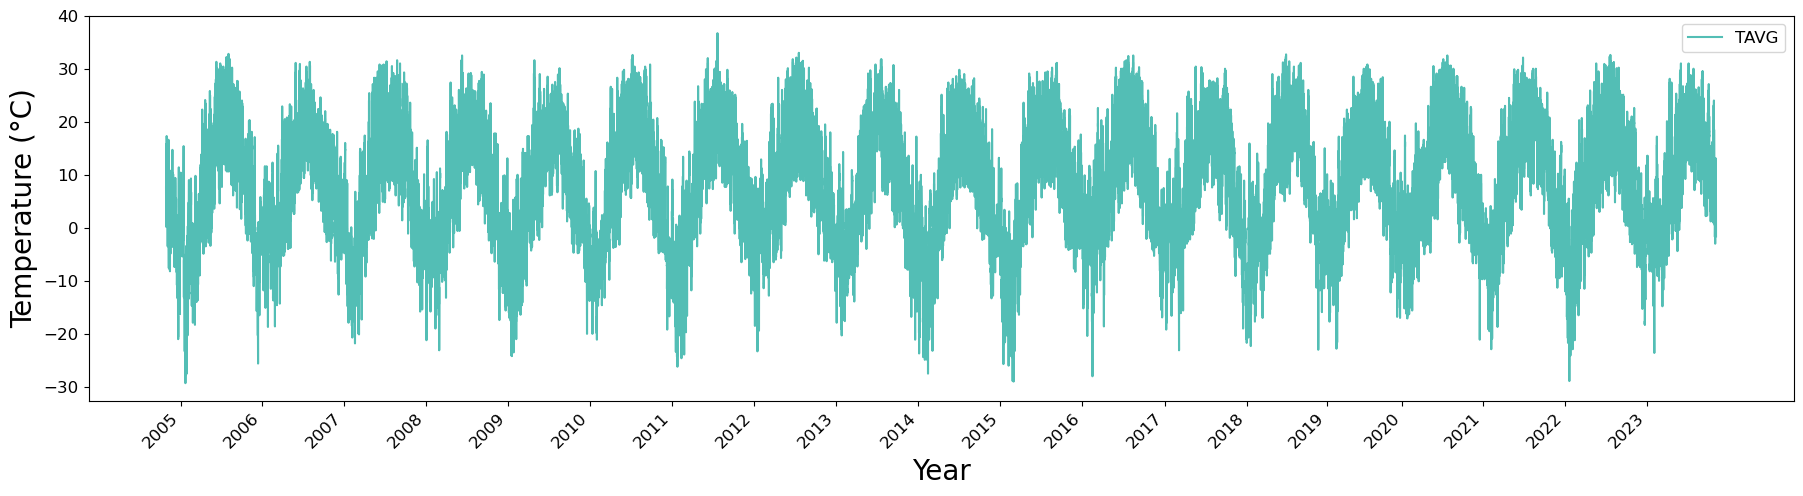

In [13]:
# violet = '#7b5aa6'
# gray = '#6d6d6d'
palette = sns.color_palette("mako_r", 6)

fontsize = 20
interval = Ithaca_hourly.shape[0]
# find beginning of each year, used for xtick labels
years_txt, years = np.unique(Ithaca_hourly.Time.dt.year, return_index = True)

fig_overall, ax = plt.subplots(1,1, figsize = (22,5))
sns.lineplot(x = Ithaca_hourly.index[:interval], y = Ithaca_hourly['T_HR_AVG'][:interval],
              color = palette[1], label = 'TAVG', alpha = 0.9)
ax.set_xticklabels([])
ax.set_xticks(years[1:]) # 2004 collapsed...
ax.set_xticklabels(years_txt[1:], rotation = 45, ha= 'right')
ax.tick_params(axis = 'y', labelsize = 12)
ax.tick_params(axis = 'x', labelsize = 12)
ax.set_ylabel('Temperature (°C)', fontsize = fontsize)
ax.set_xlabel('Year', fontsize = fontsize, labelpad = 5.0)
ax.legend(fontsize = 12)
plt.show()
# we see clear cyclic pattern
# Hourly plot is more noisy. but I think both work.

### Initial Model

#### 0. train val split

In [14]:
### train val split: ~ 8:2
Ithaca_hourly_train = Ithaca_hourly[Ithaca_hourly.Time.dt.year < 2020]
Ithaca_hourly_val = Ithaca_hourly[Ithaca_hourly.Time.dt.year >=2020]
print(f'training set length = {Ithaca_hourly_train.shape[0]}\n val set length = {Ithaca_hourly_val.shape[0]}')

training set length = 131871
 val set length = 33442


#### 1. look at ACF, PACF, run KPSS, ADF test for stationarity

In [15]:
### Determine dependence order by plotting ACF
n_lags_ar = 365*24*10
n_lags_ma = 365
acf_sm = acf(Ithaca_hourly_train.T_HR_AVG, nlags = n_lags_ar)
pacf_sm = pacf(Ithaca_hourly_train.T_HR_AVG, nlags = n_lags_ma)

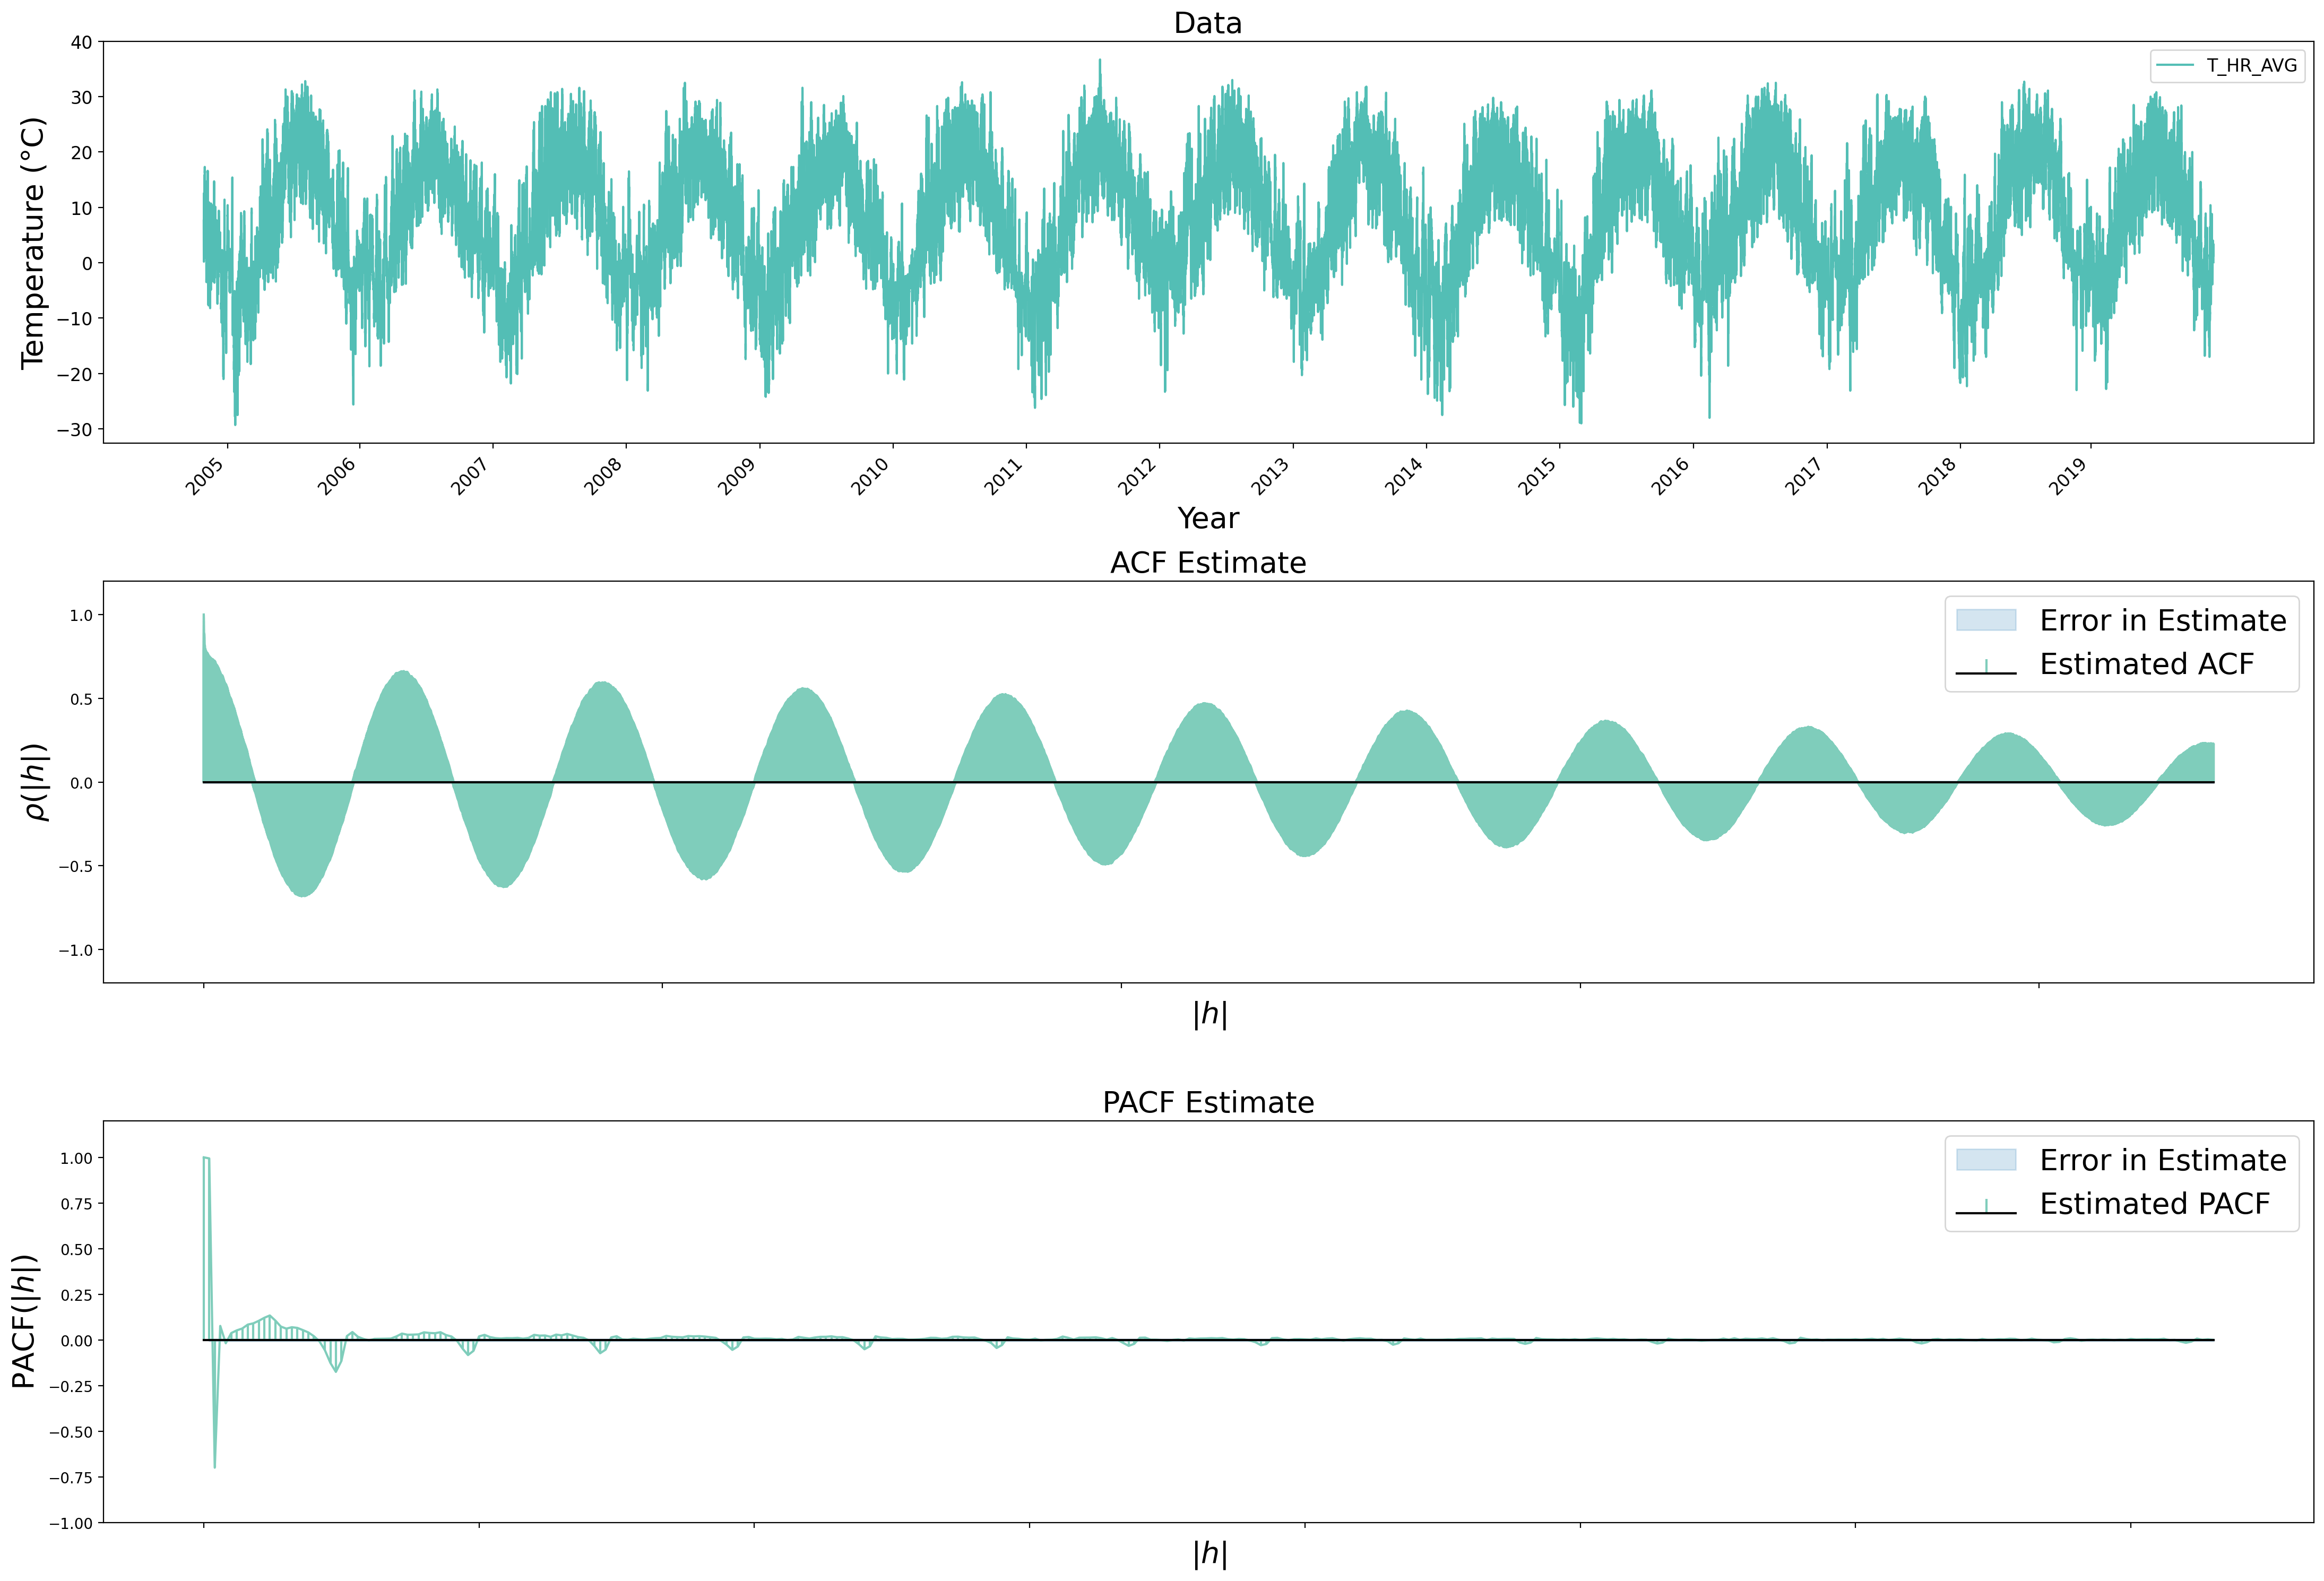

In [16]:
### Plot
plot_triple(Ithaca_hourly_train, n_lags_ar, n_lags_ma, acf_sm, pacf_sm, col = 'T_HR_AVG', fig_name = 'raw_data')

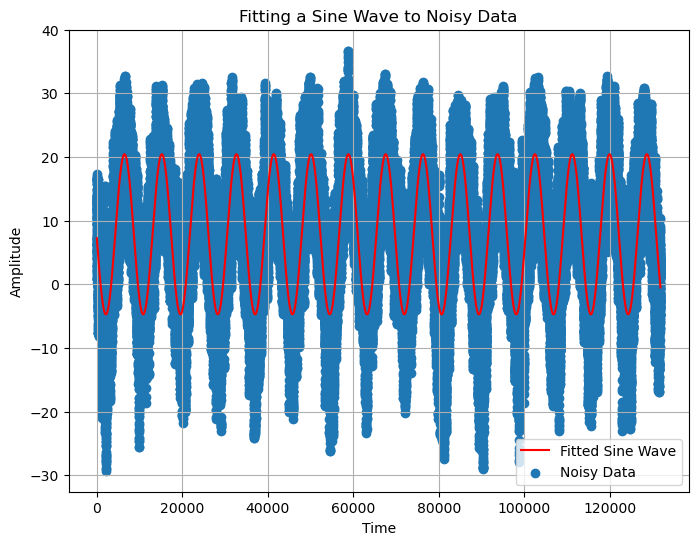

Fitted Amplitude: 12.581674976681729
Fitted Frequency: 15.000000816836682
Fitted Phase: 3.1901986869324146
Fitted Offset: 7.854757878323396


In [88]:
# fit sine wave to the data
t = np.linspace(0, len(Ithaca_hourly_train.T_HR_AVG), len(Ithaca_hourly_train.T_HR_AVG))
fitted_sine_params = fit_sine_wave(t, Ithaca_hourly_train.T_HR_AVG, initial_guess = [30, 15, np.pi, 0])

In [89]:
# remove seasonality
seasonality_sine_wave = sine_function(t, fitted_sine_params)
Ithaca_hourly_train_no_season = Ithaca_hourly_train.join(pd.DataFrame(Ithaca_hourly_train.T_HR_AVG - seasonality_sine_wave),
                                             how = 'right', rsuffix = '_sub').reset_index()

In [90]:
Ithaca_hourly_train_no_season

,index,UTC_DATE,UTC_TIME,T_HR_AVG,Time,T_HR_AVG_sub
0,0,20041028,0,7.6,2004-10-28 00:00:00,0.356547
1,1,20041028,100,7.0,2004-10-28 01:00:00,-0.234407
2,2,20041028,200,6.2,2004-10-28 02:00:00,-1.025362
3,3,20041028,300,4.7,2004-10-28 03:00:00,-2.516317
4,4,20041028,400,3.3,2004-10-28 04:00:00,-3.907272
...,...,...,...,...,...,...
131866,131866,20191231,1900,3.3,2019-12-31 19:00:00,3.765339
131867,131867,20191231,2000,3.2,2019-12-31 20:00:00,3.672130
131868,131868,20191231,2100,2.6,2019-12-31 21:00:00,3.078918
131869,131869,20191231,2200,1.9,2019-12-31 22:00:00,2.385701


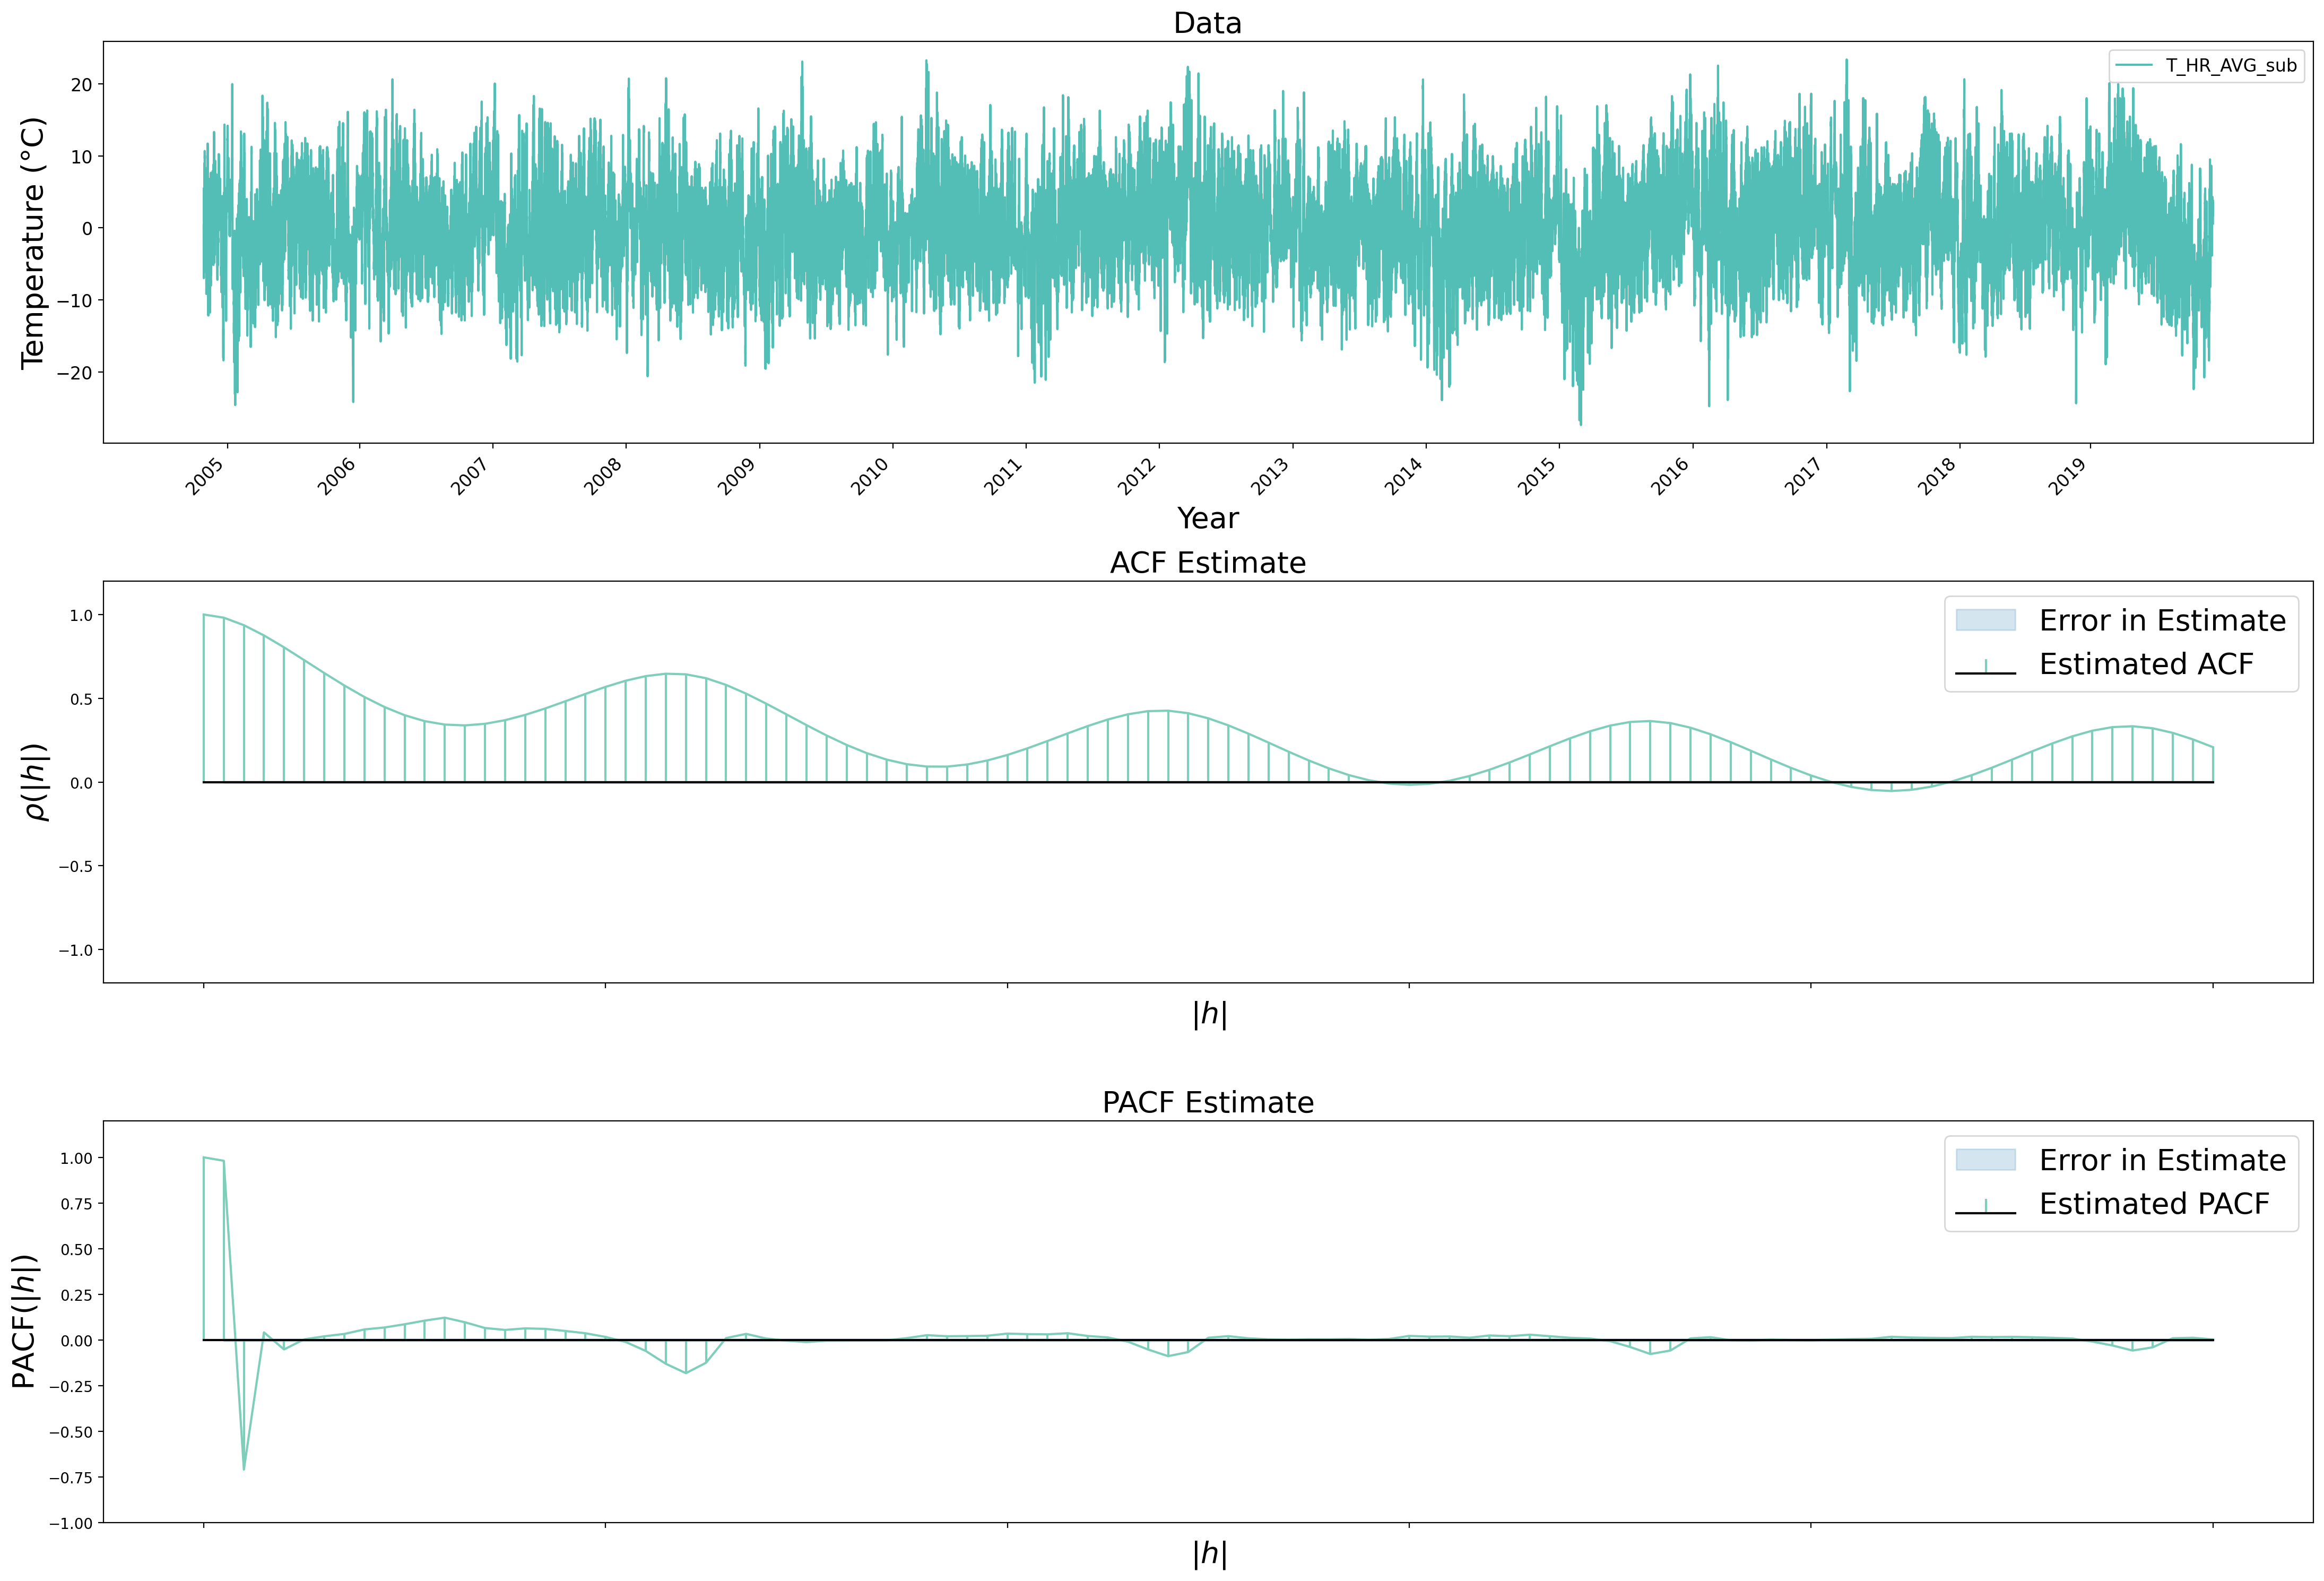

In [91]:
### plot without seasonality

n_lags_ar = 100
n_lags_ma = 100
acf_no_season_sm = acf(Ithaca_hourly_train_no_season.T_HR_AVG_sub, nlags = n_lags_ar)
pacf_no_season_sm = pacf(Ithaca_hourly_train_no_season.T_HR_AVG_sub, nlags = n_lags_ma)

plot_triple(Ithaca_hourly_train_no_season, n_lags_ar, n_lags_ma, acf_sm = acf_no_season_sm,
            pacf_sm = pacf_no_season_sm, col = 'T_HR_AVG_sub', fig_name = 'drop_seasonality')

In [92]:
### check stationarity
adfuller(Ithaca_hourly_train_no_season.T_HR_AVG_sub) # seem to be stationary

(-29.039273294519777,
 0.0,
 73,
 131797,
 {'1%': -3.430399617421998,
  '5%': -2.8615619301814723,
  '10%': -2.5667816726580504},
 300505.05935879337)

#### 2. Deal with P, Q (seasonal AR & MA), as per [pts4](http://www.stat.ucla.edu/~frederic/221/W21/tsa4.pdf)
- Seems to lead to more satisfactory results if deal with seasonal first

##### 3.2.1 FFT + ARMA

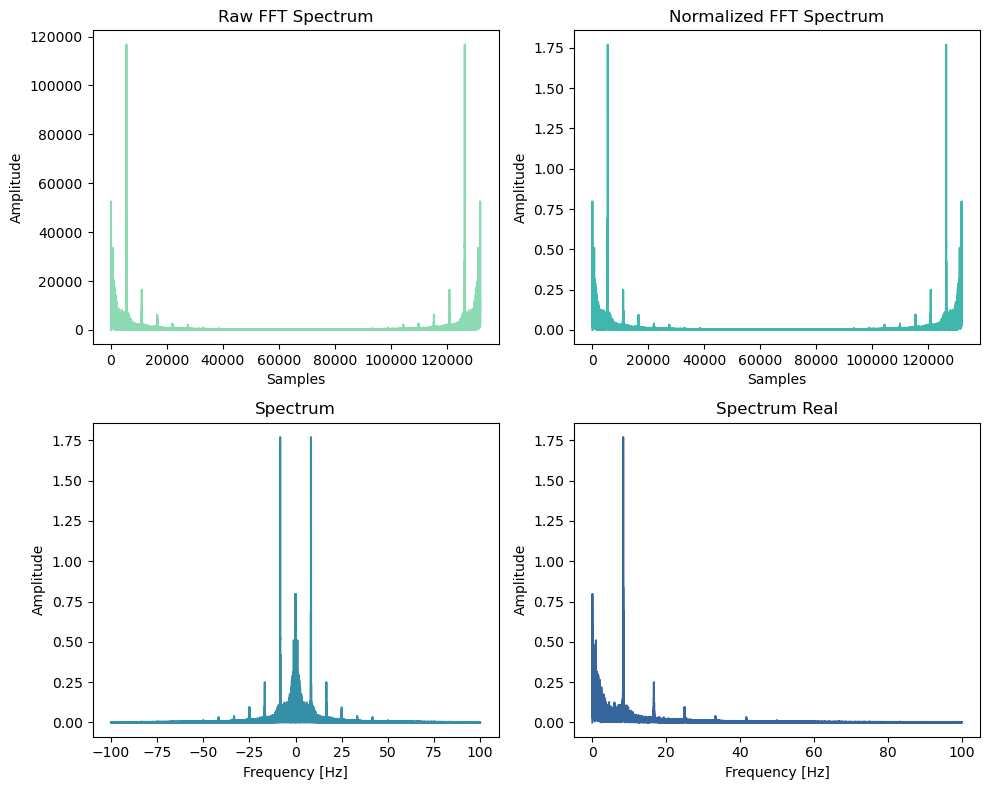

In [99]:
## take a look at fft
## https://towardsdatascience.com/fourier-transform-the-practical-python-implementation-acdd32f1b96a

signal = np.array(Ithaca_hourly_train_no_season.T_HR_AVG_sub)
T = len(signal)
normalize = T/2
fft_result = fft(signal)
sampling_rate = 200
frequency_axis = fftfreq(T, d = 1.0/sampling_rate)
norm_amplitude = np.abs(fft_result)/normalize
freq = rfftfreq(T, d = 1/sampling_rate)

fig, ax = plt.subplots(2,2, figsize = (10,8))

# the spectrum |Xk|
ax[0,0].plot(np.abs(fft_result), color = palette[0])
ax[0,0].set_ylabel('Amplitude')
ax[0,0].set_xlabel('Samples')
ax[0,0].set_title('Raw FFT Spectrum')

# Plot the normalized FFT (|Xk|)/(N/2)
ax[0,1].plot(norm_amplitude, color = palette[1])
ax[0,1].set_ylabel('Amplitude')
ax[0,1].set_xlabel('Samples')
ax[0,1].set_title('Normalized FFT Spectrum')

# Plot frequency vs. amplitude
ax[1,0].plot(frequency_axis, norm_amplitude, color = palette[2])
ax[1,0].set_ylabel('Amplitude')
ax[1,0].set_xlabel('Frequency [Hz]')
ax[1,0].set_title('Spectrum')

# Plot only the spectrum for real-values signal data
ax[1,1].plot(freq, 2*np.abs(rfft(signal))/T, color = palette[3])
ax[1,1].set_ylabel('Amplitude')
ax[1,1].set_xlabel('Frequency [Hz]')
ax[1,1].set_title('Spectrum Real')
plt.tight_layout()


fig.savefig('fft.png', bbox_inches = 'tight')

###### TODO: fit seasonality with frequencies extracted by FFT


##### 3.2.2 Just use apparent cycles

##### 3.4 model search

In [ ]:
p, q, d = range(2,4), range(8,10,2), range(0,1)
config_list = list(itertools.product(p, d, q))
scores = grid_search(Ithaca_daily_train, Ithaca_daily_val, col = 'T_AVG_trig_sub',
                     n_val = len(Ithaca_daily_val), cfg_list = config_list, parallel = False)


In [ ]:
## > Model[(0, 0, 1)] 4.5253
## > Model[(0, 0, 2)] 4.0678
## > Model[(0, 0, 3)] 3.9000
## > Model[(1, 0, 0)] 3.6928
## > Model[(1, 0, 1)] 3.7203
## > Model[(1, 0, 2)] 3.5966
## > Model[(1, 0, 3)] 3.4710
## > Model[(2, 0, 0)] 3.7281
## > Model[(2, 0, 1)] 3.6881
## > Model[(2, 0, 2)] 3.4423
## > Model[(2, 0, 3)] 3.4434
## > Model[(3, 0, 0)] 3.6195
## > Model[(3, 0, 1)] 3.4625
## > Model[(3, 0, 2)] 3.4430
## > Model[(3, 0, 3)] 3.4429
## > Model[(2, 0, 4)] 3.4446
## > Model[(2, 0, 6)] 3.4492
## > Model[(2, 0, 8)] 3.4478
##
##
##

##### 3.5 tentative model fitting

In [ ]:
## currently, within the limited search space, I find (p,d,q) = (2,0,2) return the best walk-forward validation rmse.
## Since I only include train & val set. I'll refit the model, report residuals, plot graphs.

### Random Trial

In [ ]:
## Let's aggregate by month
nyc_monthly = nyc_daily_drop.groupby(['year','month']).mean()
nyc_monthly.reset_index(inplace = True)

fontsize = 12
fig_overall, ax = plt.subplots(1,1, figsize = (12,4))
sns.lineplot(x = nyc_monthly.index, y = nyc_monthly['TMAX'],
              color = palette[1], label = 'TMAX', alpha = 0.9)
# sns.lineplot(x = nyc_monthly.index, y = nyc_monthly['TMIN'],
#               color = palette[-1], label = 'TMIN', alpha = 0.9)
ax.set_xticklabels([])
ax.set_xticks([])
ax.tick_params(axis = 'y', labelsize = 10)
ax.set_ylabel('Temperature (°F)', fontsize = fontsize)
ax.set_xlabel('Date', fontsize = fontsize)
ax.legend(fontsize = 12)
plt.show()

In [ ]:
nyc_monthly.index

##### try fitting ARIMA data after subtracting the sine wave

In [103]:
## Does not work. running for 47 mins without result
## search for the best model
# Or maybe just use auto_arima
# P <= 3, Q <= 1; p <= 3, q <= 27
from pmdarima import auto_arima

arima = auto_arima(Ithaca_hourly_train_no_season.T_HR_AVG_sub, d = 0,
                    start_p = 1,
                    start_q = 1,
                    max_p = 3,
                    max_q = 5,
                    seasonal = False,
                    D = 0,
                    information_criterion='aic')

In [105]:
arima.summary() # got arima(2,0,5)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               131871
Model:               SARIMAX(2, 0, 5)   Log Likelihood             -162188.091
Date:                Mon, 20 Nov 2023   AIC                         324392.181
Time:                        17:25:00   BIC                         324470.498
Sample:                             0   HQIC                        324415.657
                             - 131871                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6531      0.010    172.126      0.000       1.634       1.672
ar.L2         -0.6883      0.009    -77.587      0.000      -0.706      -0.671
ma.L1          0.0529      0.010      5.529      0.000       0.034       0.072
ma.L2         -0.0386      0.008     -5.044      0.000      -0.054      -0.024
ma.L3          0.0223      0.005      4.096      0.000       0.012       0.033
ma.L4          0.0361      0.004      8.111      0.000       0.027       0.045
ma.L5          0.0259      0.004      7.161      0.000       0.019       0.033
sigma2         0.6851      0.001    573.538      0.000       0.683       0.687
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):            568014.62
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.17
Prob(H) (two-sided):                  0.40   Kurtosis:                        13.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

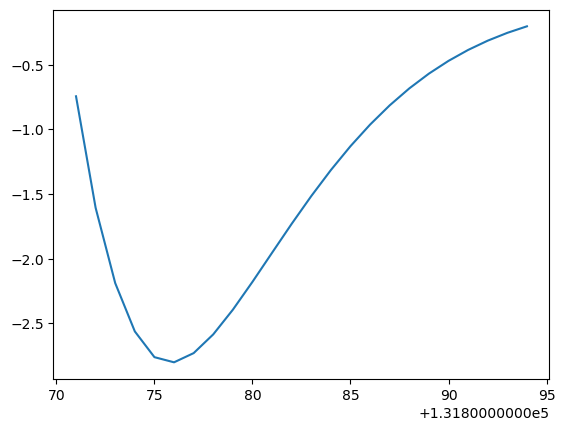

In [112]:
plt.plot(arima.predict(n_periods = 24))

In [113]:
from sklearn.metrics import mean_squared_error

data = Ithaca_hourly_train_no_season.T_HR_AVG_sub
forecast = arima.predict_in_sample()
mse = mean_squared_error(data, forecast)
print('mse: ', mse)

mse:  0.6851549989563461


##### Failed SARIMAX

In [ ]:
## search for the best model
# P <= 3, Q <= 1; p <= 3, q <= 27 -> impossible to solve for such a range. so truncate.
# Note large q won't work. Computationally expensive.

# modified utils from the following sources
# https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/
# https://www.kaggle.com/code/leandrovrabelo/climate-change-forecast-sarima-model/notebook

order_aic = [] # store AIC per model here. Complementary to CV
# forecast function
def sarima_forecast(history, config, aic = True):
    """
    order = (p,d,q)
    sorder = (P,D,Q,s)
    """
    order, sorder = config[:3], config[3:]
    # define model
    model = sarimax.SARIMAX(history, order=order,
                          seasonal_order=sorder,

                          trend=None, enforce_stationarity=False,
                          enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False) # do not print convergence message
    if aic:
      order_aic += [(config, model_fit.aic)]
    # make one step forecast
    yhat = model_fit.predict(start = len(history), end = len(history))
    return yhat[0]


# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

def walk_forward_validation(train, val, col, n_val, cfg):
      predictions = np.zeros(len(val))
      # seed history with training dataset
      history = list(train['col'])
      # step over each time-step in the test set
      for i in range(len(val)):
      # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions[i] = yhat
        # add actual observation to history for the next loop
        history.append(val[i])
        # estimate prediction error
        error = measure_rmse(val, predictions)
      return error


# score a model, return None on failure
def score_model(train, val, col, n_val, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(train, val, col, n_val, cfg)
    else:
      try:
    # never show warnings when grid searching, too noisy
          with catch_warnings():
            warnings.filterwarnings("ignore")
            result = walk_forward_validation(train, val, col, n_val, cfg)
      except:
          error = None
    # check for an interesting result
    if result is not None:
      print(' > Model[%s] %.4f' % (key, result))
    return (key, result)


# we need to set to sarimax gridsearch
def grid_search(train, val, col, n_val, cfg_list, parallel=True):
    scores = None
    if parallel:
 # execute configs in parallel
      executor = Parallel(n_jobs=-1, backend='multiprocessing')
      tasks = (delayed(score_model)(train, val, col, n_val, cfg) for cfg in cfg_list)
      scores = executor(tasks)
    else:
      scores = [score_model(train, val, col, n_val, cfg) for cfg in cfg_list]
      # remove empty results
      scores = [r for r in scores if r[1] != None]
      # sort configs by error, asc
      scores.sort(key=lambda x: x[1])
    return scores



In [ ]:
P, Q, p, q, D, s, d = range(0,4), range(1,2), range(1,2), range(1,2), range(1,2), range(365,366), range(0,1)
config_list = list(itertools.product(p, d, q, P, D, Q, s))
scores = grid_search(Ithaca_daily_train, Ithaca_daily_val, col = 'T_AVG',
                     n_val = len(Ithaca_daily_val), cfg_list = config_list, parallel = True)

In [ ]:
sarima_forecast(history = list(Ithaca_daily_train['T_AVG']), config = config_list[0]) # it is not feasible... too slow...
# Let's just try Fourier Transform first, then ARMA

In [ ]:
walk_forward_validation(Ithaca_daily_train, Ithaca_daily_val, col = 'T_AVG_trig_sub',
                        n_val = len(Ithaca_daily_val), cfg = config_list[1])